In [138]:
import cv2 as cv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [139]:
from midas.run import process, load_model
from midas.utils import read_image
# require timm==0.6.12
# or the state dict won't load (why?)
# https://github.com/isl-org/MiDaS/blob/bdc4ed64c095e026dc0a2f17cabb14d58263decb/environment.yaml#L15C7-L15C19


In [140]:
from pathlib import Path
MODEL_PATH = "dpt_swin2_tiny_256.pt"
VIDEO_PATH = "rotated.avi"
OUTPUT_PATH = "output.avi"
video_path = Path(VIDEO_PATH)
model_path = Path(MODEL_PATH)
output_path = Path(OUTPUT_PATH)
assert video_path.exists(), f"Video file does not exist at {video_path}"
assert model_path.exists(), f"Model file does not exist at {model_path}"

In [141]:
# device = torch.device("cpu") # use CPU intentionally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimize=False
side=False
height=None
square=False
grayscale=False
model_type = "dpt_swin2_tiny_256"
model, transform, net_w, net_h = load_model(device, MODEL_PATH, model_type, optimize, height, square)
print("device: {} model_type: {}".format(device, model_type))

Model loaded, number of parameters = 42M
device: cuda model_type: dpt_swin2_tiny_256


In [142]:
cap = cv.VideoCapture(VIDEO_PATH)
fps = cap.get(cv.CAP_PROP_FPS)
w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
all_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
at_frame = 120
assert at_frame < all_frames
cap.set(cv.CAP_PROP_POS_FRAMES, at_frame)
display("{}x{} @ {} FPS ({}/{})".format(w, h, fps, at_frame, all_frames))
ret, frame = cap.read()
# writer = cv.VideoWriter(OUTPUT_PATH, cv.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
if ret == True:
  if frame.ndim == 2:
      frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame = cv2.normalize(frame, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
assert ret == True
cap.release()

'1280x720 @ 30.0 FPS (90/893)'

    Input resized to 256x256 before entering the encoder


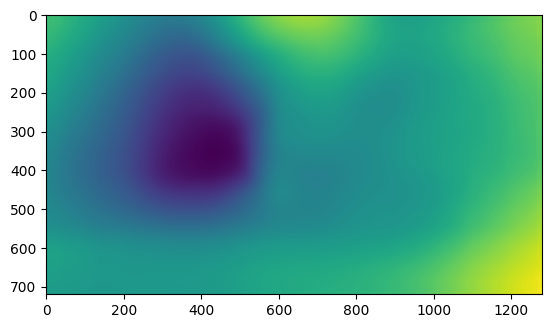

In [143]:
img = frame
img_size = img.shape[1::-1]
resized = transform({"image": img/255})["image"]
uint8_max = np.iinfo(np.uint8).max
with torch.no_grad():
  depth = process(device, model, model_type, resized, (net_w, net_h), img_size, optimize, False)
mask = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


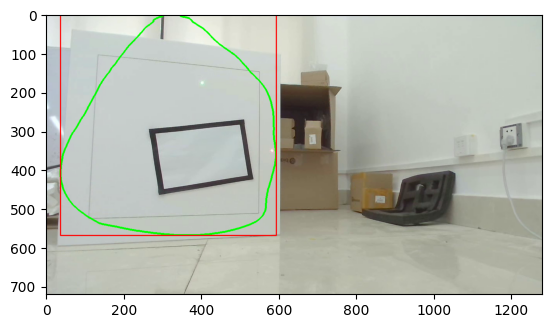

In [148]:
res = img.copy()
u8_mask = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
inverted = cv2.bitwise_not(u8_mask)
ret, limited = cv2.threshold(inverted, 0, 255, cv.THRESH_OTSU)
contours, hierarchy = cv2.findContours(limited, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
bbs = []
for contour in contours:
  area = cv2.contourArea(contour)
  cv2.drawContours(res, [contour], 0, (0, 255, 0), 3)
  if area > 100:
    box = cv2.boundingRect(contour)
    x, y, w, h = box
    bbs.append(box)
    cv2.rectangle(res, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(res)

In [145]:
depth_max = np.max(depth)
depth_min = np.min(depth)
display("max {} min {}".format(depth_max, depth_min))

'max 1433.8505859375 min 765.3133544921875'

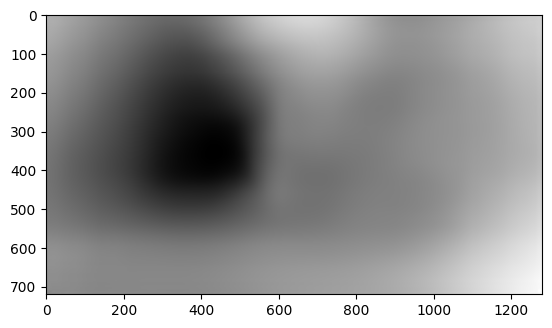

In [146]:
uint8_max = np.iinfo(np.uint8).max
normalized = cv2.normalize(depth, None, 0, uint8_max, cv2.NORM_MINMAX).astype(np.uint8)
converted = cv2.cvtColor(normalized, cv2.COLOR_GRAY2BGR)
plt.imshow(converted)

In [147]:
is_save_video = False
if is_save_video:
  cap = cv.VideoCapture(VIDEO_PATH)
  fps = cap.get(cv.CAP_PROP_FPS)
  w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
  h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
  display("{}x{} @ {} FPS".format(w, h, fps))
  writer = cv.VideoWriter(OUTPUT_PATH, cv.VideoWriter_fourcc(*'MJPG'), fps, (w, h))
  while cap.isOpened():
    ret, frame = cap.read()
    frame_now = cap.get(cv.CAP_PROP_POS_FRAMES)
    # if frame_now > 30:
    #   break
    if ret == False:
      break
    if frame.ndim == 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.normalize(frame, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
    img = frame
    img_size = img.shape[1::-1]
    resized = transform({"image": img/255})["image"]
    with torch.no_grad():
      depth = process(device, model, model_type, resized, (net_w, net_h), img_size, optimize, False)
      uint8_max = np.iinfo(np.uint8).max
      u8_mask = cv2.normalize(depth, None, 0, uint8_max, cv2.NORM_MINMAX, cv2.CV_8U)
      inverted = cv2.bitwise_not(u8_mask)
      ret, limited = cv2.threshold(inverted, 150, 255, cv.THRESH_BINARY)
      f32_mask = cv2.normalize(limited, None, 0.0, 1.0, cv2.NORM_MINMAX, cv2.CV_32F)
      f32_mask_3chan = np.repeat(f32_mask[:, :, np.newaxis], 3, axis=2)
      img_f32 = img.astype(np.float32)
      masked = cv2.multiply(img_f32, f32_mask_3chan)
      img_bgr = cv2.cvtColor(masked, cv2.COLOR_RGB2BGR)
      img_u8 = cv2.normalize(img_bgr, None, 0, uint8_max, cv2.NORM_MINMAX, cv2.CV_8U).astype(np.uint8)
      writer.write(img_u8)
  writer.release()